In [1]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import keras
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import seaborn as sns

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/', 
                                              target_size=(256, 256), 
                                              batch_size=32, 
                                              class_mode='categorical')
test_set = test_datagen.flow_from_directory('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/', 
                                            target_size=(256, 256), 
                                            batch_size=32, 
                                            class_mode='categorical',
                                            shuffle=False)

Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
train_path='/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/'
No_images_per_class = []
Class_name = []
for i in os.listdir(train_path):
  train_class = os.listdir(os.path.join(train_path, i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in No Impairment = 2560 

Number of images in Very Mild Impairment = 2560 

Number of images in Moderate Impairment = 2560 

Number of images in Mild Impairment = 2560 



In [5]:
test_path='/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/'
No_images_per_class = []
Class_name = []
for i in os.listdir(test_path):
  train_class = os.listdir(os.path.join(test_path, i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in No Impairment = 640 

Number of images in Very Mild Impairment = 448 

Number of images in Moderate Impairment = 12 

Number of images in Mild Impairment = 179 



In [6]:
from glob import glob
# useful for getting number of output classes
folders = glob('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/*')
print(len(folders))

4


In [7]:
from keras.applications.vgg16 import VGG16
img_width, img_height = 256,256
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

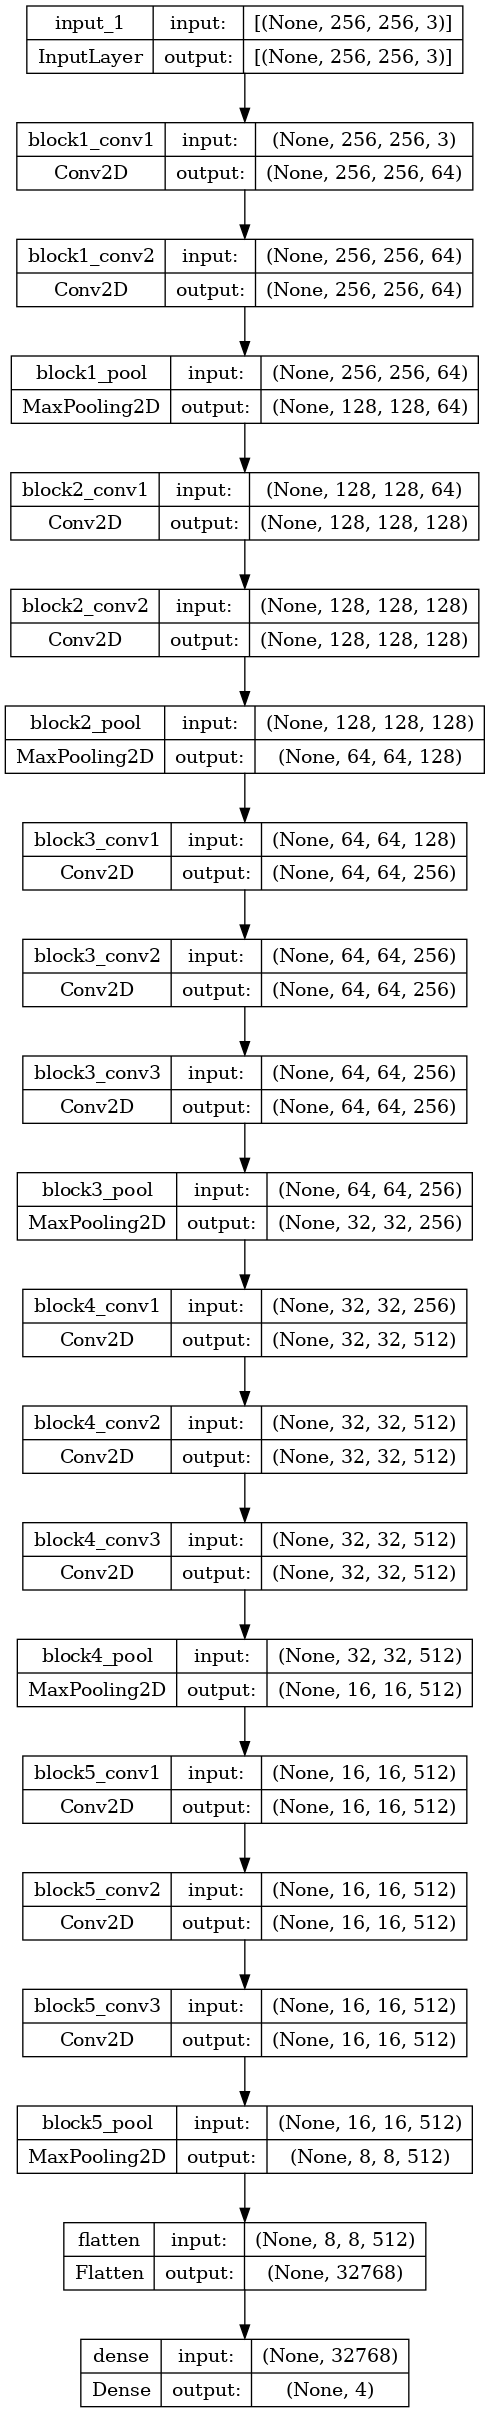

In [8]:
plot_model(model, to_file='vgg16.png', show_shapes=True, show_layer_names=True) #visulaize the model

In [9]:
lr = 0.001
model.compile(Adam(learning_rate=lr),loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
history = model.fit(train_set,
                    steps_per_epoch=train_set.samples//32,
                    epochs=100,
                    validation_data=test_set,
                    validation_steps=test_set.samples//32)

Epoch 1/100
320/320 [==============================] - 208s 618ms/step - loss: 0.7779 - accuracy: 0.6993 - val_loss: 0.7648 - val_accuracy: 0.6603
Epoch 2/100
320/320 [==============================] - 155s 484ms/step - loss: 0.4669 - accuracy: 0.8059 - val_loss: 0.6638 - val_accuracy: 0.7155
Epoch 3/100
320/320 [==============================] - 156s 487ms/step - loss: 0.4437 - accuracy: 0.8198 - val_loss: 0.6522 - val_accuracy: 0.7244
Epoch 4/100
320/320 [==============================] - 154s 481ms/step - loss: 0.3966 - accuracy: 0.8385 - val_loss: 0.5741 - val_accuracy: 0.7516
Epoch 5/100
320/320 [==============================] - 156s 487ms/step - loss: 0.4020 - accuracy: 0.8398 - val_loss: 0.5623 - val_accuracy: 0.7732
Epoch 6/100
320/320 [==============================] - 154s 480ms/step - loss: 0.3551 - accuracy: 0.8623 - val_loss: 0.7582 - val_accuracy: 0.7067
Epoch 7/100
320/320 [==============================] - 154s 482ms/step - loss: 0.3139 - accuracy: 0.8694 - val_loss: 0

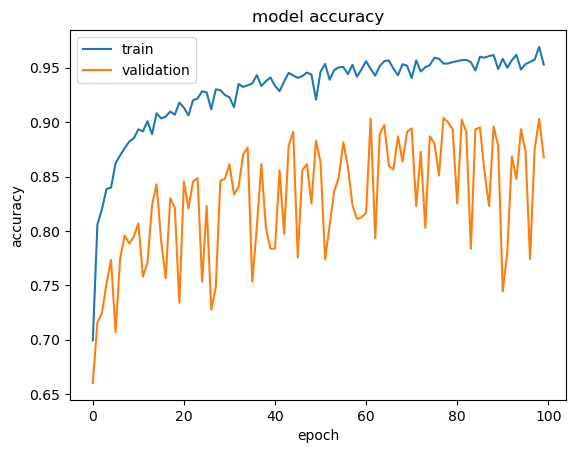

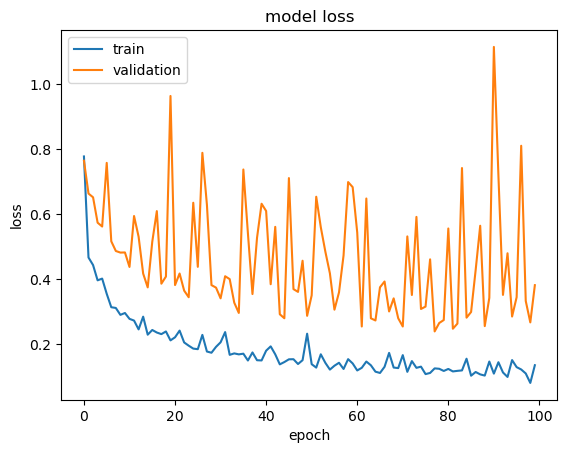

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

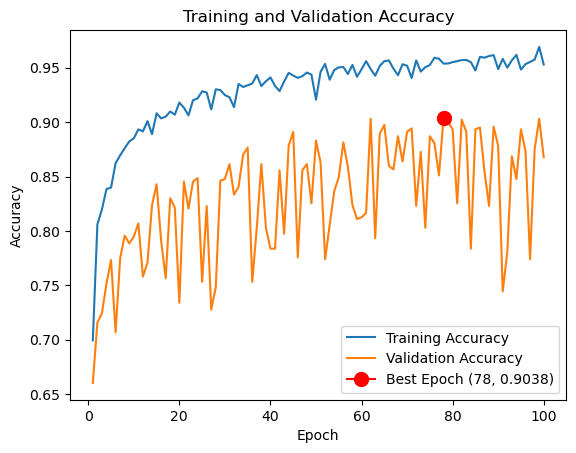

In [12]:
# Extracting the validation accuracy values and finding the epoch with the highest value
val_acc = history.history['val_accuracy']
best_epoch = val_acc.index(max(val_acc)) + 1  # Add 1 to convert index to epoch number

# Plotting the training history
epochs = range(1, len(val_acc) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Highlighting the epoch with the highest validation accuracy
plt.plot(best_epoch, val_acc[best_epoch - 1], marker='o', markersize=10, label=f'Best Epoch ({best_epoch}, {val_acc[best_epoch - 1]:.4f})', color='red')

# Adding plot labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [13]:
from tensorflow.keras.models import load_model

model.save('best_weights.h5')

In [14]:
# load model
model = load_model('/kaggle/working/best_weights.h5')

In [15]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_set, steps = test_set.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

39/39 [==============================] - 7s 177ms/step - loss: 0.3817 - accuracy: 0.8678
Accuracy Test : 0.8677884340286255


In [16]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_set.classes, y_pred)
cr = classification_report(test_set.classes, y_pred, target_names=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])

40/40 [==============================] - 13s 317ms/step


In [17]:
print(cm)
print(cr)

[[116   0  25  38]
 [  0  12   0   0]
 [  0   0 609  31]
 [  0   0  76 372]]
                      precision    recall  f1-score   support

     Mild Impairment       1.00      0.65      0.79       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.86      0.95      0.90       640
Very Mild Impairment       0.84      0.83      0.84       448

            accuracy                           0.87      1279
           macro avg       0.93      0.86      0.88      1279
        weighted avg       0.87      0.87      0.86      1279



In [18]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_pred,test_set.classes)))
print('Cohen Kappa Score: {:.2f}'.format(cohen_kappa_score(y_pred,test_set.classes)))
print('Recall: {:.2f}'.format(recall_score(test_set.classes, y_pred, average='micro')))
print('F1-score: {:.2f}'.format(f1_score(test_set.classes, y_pred, average='micro')))
print('Precision: {:.2f}'.format(precision_score(test_set.classes, y_pred, average='macro')))


Accuracy: 0.87

Cohen Kappa Score: 0.77
Recall: 0.87
F1-score: 0.87
Precision: 0.93


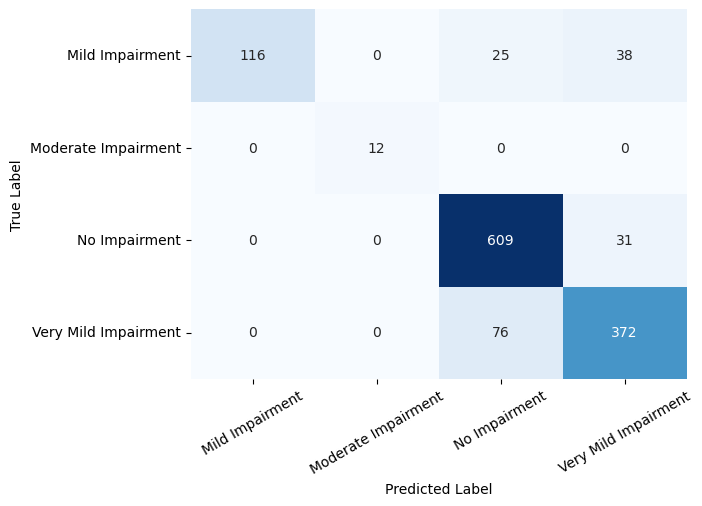

In [19]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], yticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], cbar=False)
plt.xticks(rotation=30)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()